# Students
- Gabriele Bellavia - 2160133
- Luigi Belli - 2152859
- Margherita Lera - 2142875
- Giovanni Andrea Maida - 2159404

# Gradient descent & Deep Neural Networks

From here we begin the execution of the assigned task.
We build the neural network using the `Sequential()` class from Keras, called **model**, that allows building the NN layer by layer. We add $3$ `Dense()` hidden layers each consisting of $20$ units on top of an input layer, and lastly we add an output layer.

For the purpose of hyper-parameter optimization we implement a random search using the "Keras Tuner" package. Random search is a family of optimization methods that do not require the gradient of the optimization problem.

We optimized the following hyper-parameters searching through the associated options:
- Optimizer: {Adam, SGD with Nesterov momentum, RMSprop, AdaMax, AdaGrad}
- Non-linear activation function: {sigmoid, ReLU, ELU}
- Dropout value: {$0.0, 0.1, 0.2$}
- Learning rate: {$10^{-6}, 10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}$}

Let's dive deeper into what these are.

Optimization algorithms are meant to reduce loss acting on weights of the neural network. We tried the following types:
- **Stochastic Gradient Descent with Nesterov Momentum**  gradient descent is an algorythm that follows the negative gradient of a function to locate the minimum, while momentum is an approach that accelerates the progress of the search to get over flat areas. The Nesterov momentum is an extension of momentum that involves computing the partial derivative of the projected update rhater thatn the derivative of the current variable value. It handles better saddle point, reduce oscillations and should lead to faster convergence.
- **RMSprop**  keeps a moving average of the squared gradients for each weight of the model, adapts the learning rate based on said average, and normalizes the gradients to avoid too big or too small values.
- **Adam (ADAptive Moment estimation)**  combines the ideas of momentum and RMSprop. It is effective in handling noisy data, and it adapts the learning rate for each parameter, leading to faster convergence
- **AdaMax**  is a variant of Adam, it modifies how the learning rate is adapted to each parameter, here is adapted based on the infinity norm, which is the maximum absolute value of the gradient.
- **Adagrad**  is a variation of Adam that accumulates the sum of squared past gradients, making the learning rate to decrease continuously, works for sparse data.

Activation functions are applied to the output of a neuron and it determines if the neuron should be turned on or off. This introduces non-linearity on the model so it can learn complex patterns.

Dropout is a regulatization technique that prevents overfitting by random setting a fraction of neurons to zero during the training.


Constructing a Deep Neural Network to solve ML problems can be syntesized on following key-steps [Mehta]{\[Mehta et al.\]}:

1. Load and process the data
2. Define the model and its architecture
3. Choose the optimizer and the cost function
4. Train the model
5. Evaluate the model performance on the unseen test data
6. Modify the hyperparameters to optimize performance for the specific data set

Step 1 is given with the problem's environment while steps 2 to 6 can be automatized using Random Search method.

For any NN, , it is necessary to tune hyper-parameters such as the ones mentioned above, but finding the best combinations of them could be a lenghty and expensive process. There are two main approaches.
- Grid Search, that tries out all the possible combinations of hyperparameters in a predefined grid.
- Random Search instead picks samples randomly from the hyperparameter space, previously defined. This approach is less computationally expensive because it explores a random subset of hyper-parameters space.

We will implement the latter:

In [1]:
import numpy as np

import os
import json
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras_tuner
from kerastuner.engine.trial import Trial
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import StandardScaler

rng = np.random.default_rng(1758)

plt.rcParams['font.size'] = 13



%run useful.py

2025-03-03 22:09:57.238704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-03 22:09:57.251553: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-03 22:09:57.255331: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 22:09:57.264504: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_518661/1410722912.py

### Read and prepare data

In [2]:
TYPE=3
# data point size
L=8
# span of each component
B=10
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")

In [3]:
def Standardize(x,m,s):
    """
    Rescales each component using its mean and standard deviation
    """
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss

def prepare_data(x,y):
    """
    Does rescaling, and divides the input data into training and test set.
    """
    perc_train=0.8
    
    N=len(x)
    N_train = int(perc_train * N)
    x_mean = np.mean(x,axis=0)
    x_std  = np.std(x,axis=0)
    
    x = Standardize(x,x_mean,x_std)
    
    (x_train, y_train) = (x[0:N_train],y[0:N_train])
    (x_test, y_test) = (x[N_train:],y[N_train:])
    return x_train,y_train,x_test,y_test

In [4]:
x_train,y_train,x_test,y_test=prepare_data(x,y)

## 1) Random Search of best hyperparameters

In [5]:
#### We edited the class RandomSearch to be able to plot scores of each trials ###############################

class RandomSearch(keras_tuner.RandomSearch):
    histories = {}

    def on_epoch_end(self, trial, model, epoch, logs=None):
        trial_id = trial.trial_id
        trial_history = self.histories.setdefault(trial_id, {})
        for metric, value in logs.items(): trial_history.setdefault(metric, []).append(value)

    def on_trial_end(self, trial):
        super().on_trial_end(trial)

        self.plot_and_save_history(trial)

    def plot_and_save_history(self, trial: Trial):
        trial_id = trial.trial_id
        trial_history = self.histories[trial_id]

        # Create directory for trial if it doesn't exist
        trial_dir = self.get_trial_dir(trial_id)
        os.makedirs(trial_dir, exist_ok=True)

        # Save history to JSON file
        history_file = os.path.join(trial_dir, "history.json")
        with open(history_file, "w") as f:
            json.dump(trial_history, f, indent=4)

    def plot_best_trials(self, num_models=5, wrap_columns=4, smooth_factor=0.5, figure_size=(20,5), suffix=""):
        best_trials = self.oracle.get_best_trials(num_models)
        num_trials = len(best_trials)

        rows = (num_trials - 1) // wrap_columns + 1
        cols = min(num_trials, wrap_columns)

        fig, axes = plt.subplots(rows, cols, figsize=figure_size, layout='constrained')

        for i, trial in enumerate(best_trials):
            trial_id = trial.trial_id
            trial_dir = self.get_trial_dir(trial_id)
            history_file = os.path.join(trial_dir, "history.json")

            with open(history_file, "r") as f:
                trial_history = json.load(f)

            ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
            for metric_name, metric_values in trial_history.items():
                smoothed_values = self.smooth_values(metric_values, smooth_factor)
                ax.plot(smoothed_values, label=f"{metric_name}")

            ax.set_title(f"Trial {trial_id}")
            ax.set_xlabel("Step")
            ax.set_ylabel("Value")
            ax.yaxis.set_major_locator(MultipleLocator(0.1))
            ax.set_xlim(0, 400)
            ax.legend(fontsize=9)
        

    def smooth_values(self, values, smooth_factor):
        """
        Smooth values with moving average
        In this example implementation, the smooth_values method takes in a list of values and a smooth_factor between 0 and 1.
        It first checks if the smooth_factor is within the valid range (0 to 1). If it's not, it returns the original values without any smoothing.
        Next, it calculates the number of smoothed values based on the smooth_factor.
        It then iterates over the values list, applying the simple moving average (SMA) technique to calculate the smoothed value at each index.
        The number of values used for the moving average calculation increases gradually until it reaches the desired number of smoothed values.
        After that, a fixed window size is used for calculating the moving average.
        """
        if smooth_factor <= 0.0 or smooth_factor >= 1.0:
            return values

        num_values = len(values)
        num_smoothed_values = int(num_values * (1 - smooth_factor)) + 1
        smoothed_values = []

        for i in range(num_smoothed_values):
            start_index = max(0, i - num_smoothed_values + 1)
            end_index = i + 1
            subset = values[start_index:end_index]
            smoothed_value = sum(subset) / len(subset)
            smoothed_values.append(smoothed_value)

        for i in range(num_smoothed_values, num_values):
            start_index = i - num_smoothed_values + 1
            end_index = i + 1
            subset = values[start_index:end_index]
            smoothed_value = sum(subset) / num_smoothed_values
            smoothed_values.append(smoothed_value)

        return smoothed_values
    
    
#### END of the RandomSearch() class editing ##########################################################

### Define the NN model with Keras / Tensorflow

In [6]:
def build_model(hp):
    model = Sequential()
    
    # Input layer
    model.add(Dense(L, input_shape=(L,), activation='relu'))
    hidd_active = hp.Choice('hidd_activation', ['sigmoid','relu','elu'])
    
    # 3 hidden layers
    for layer_num in range(1, 4):
        model.add(Dense(20, activation=hidd_active))
        model.add(Dropout(hp.Float(f'Dropout_{layer_num}', min_value=0, max_value=0.2, step=0.1)))

    # Output layer
    model.add(Dense(1,activation='sigmoid'))
    learning_rate = hp.Choice('lr', [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
    hyper_optimizer = hp.Choice('optimizer', ['adam', 'sgd_nesterov', 'RMSprop', 'adamax', 'adagrad'])

    # Define sgd_nesterov
    if hyper_optimizer == 'sgd_nesterov': hyper_optimizer = SGD(learning_rate=learning_rate, nesterov=True)
        
    model.compile(loss='binary_crossentropy', optimizer=hyper_optimizer, metrics=["accuracy"])
    return model

### Random Search of the best model

In [7]:
build_model(keras_tuner.HyperParameters()) # Construction of the model

# tuner definition
tuner = RandomSearch(hypermodel=build_model, 
                                 objective="val_accuracy", # Tuner objective to maximize/minimize. We choose to maximize the validation
                                 ## accuracy so as to pick a lower epoch number in case of overfitting.
                                 max_trials=15,  # Number of models to be built.
                                 executions_per_trial=1, # originally it was set at 3 trials in case of some errors happening due to
                                 ## limited RAM or whatsoever.
                                 overwrite=True, # avoids considering old models of previous runs.
                                 project_name='search'# directory where trials are saved.
                                )
tuner.search(x_train[200:], y_train[200:], epochs=400, validation_data=(x_train[:200], y_train[:200])) # We use 200 points from the training set as the validation set

Trial 15 Complete [00h 00m 28s]
val_accuracy: 0.9300000071525574

Best val_accuracy So Far: 0.9750000238418579
Total elapsed time: 00h 07m 01s


In [12]:
# We only display the selected best models' results for readability
tuner.results_summary(num_trials=4)
models = tuner.get_best_models(num_models=4) # We selected models with validation accuracy above 0.95

Results summary
Results in ./search
Showing 4 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
hidd_activation: elu
Dropout_1: 0.1
Dropout_2: 0.2
Dropout_3: 0.1
lr: 1e-06
optimizer: RMSprop
Score: 0.9750000238418579

Trial 04 summary
Hyperparameters:
hidd_activation: elu
Dropout_1: 0.1
Dropout_2: 0.2
Dropout_3: 0.1
lr: 0.0001
optimizer: RMSprop
Score: 0.9750000238418579

Trial 03 summary
Hyperparameters:
hidd_activation: relu
Dropout_1: 0.0
Dropout_2: 0.2
Dropout_3: 0.2
lr: 1e-05
optimizer: RMSprop
Score: 0.9549999833106995

Trial 05 summary
Hyperparameters:
hidd_activation: relu
Dropout_1: 0.0
Dropout_2: 0.0
Dropout_3: 0.1
lr: 0.01
optimizer: sgd_nesterov
Score: 0.9549999833106995


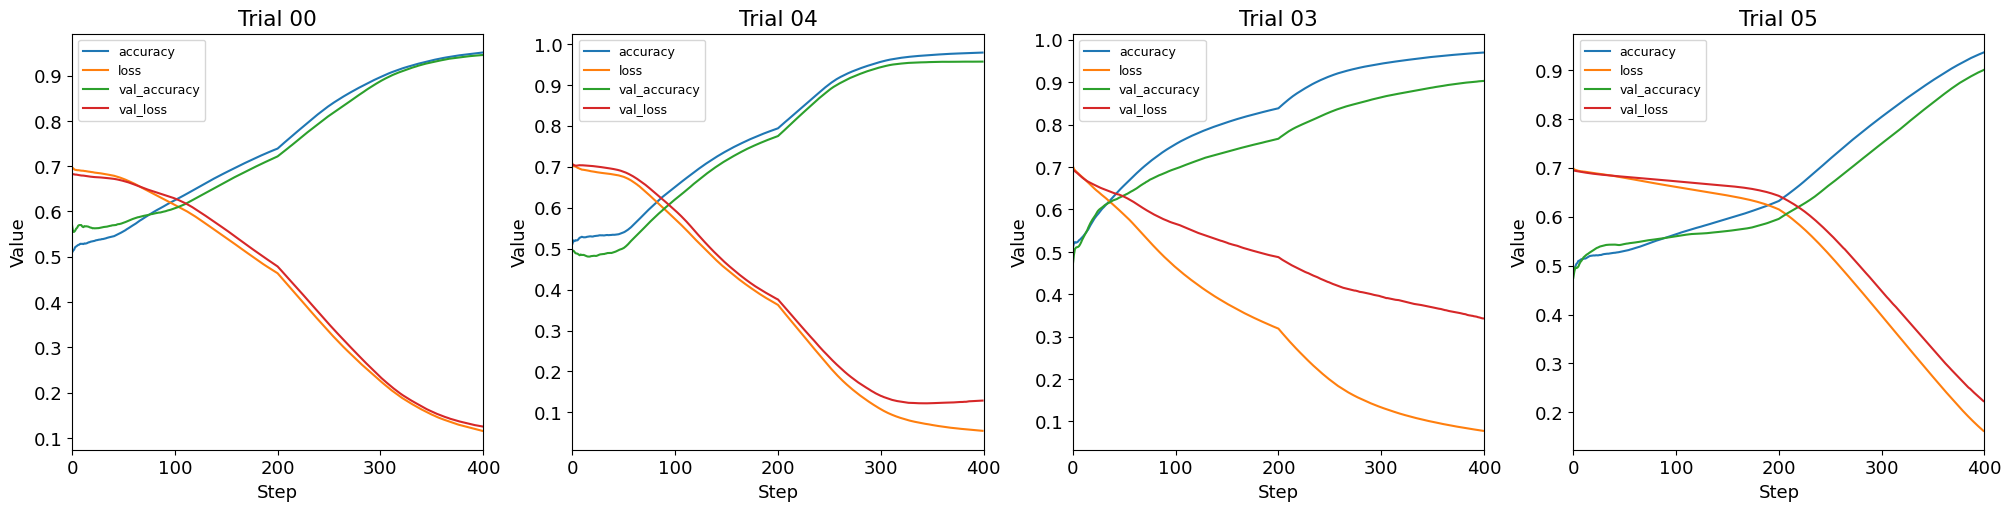

In [13]:
tuner.plot_best_trials(num_models=4) # Scores vs epoch of the best 4 models.
plt.show()

### Cross Validation

We perform a K-fold cross validation to compare and select the best model over the chosen ones.

In [14]:
def k_fold_cross_validation(x_train, y_train, k, models):
    # Initialize holders
    best = -1 # Best model
    best_perf = -1 # Best score
    results = [] # List to store performance of each model
    
    # Divide training set in K folds
    idx = rng.permutation(np.arange(x_train.shape[0]))
    x_folds, y_folds = np.array_split(x_train[idx, :], k), np.array_split(y_train[idx], k)
    
    for i in range(len(models)):
        model_perf = []  # Stores each k-
        for test in range(k): #k-fold cross-validation
            x_train_fold = np.concatenate([x for i, x in enumerate(x_folds) if i != test])
            y_train_fold = np.concatenate([x for i, x in enumerate(y_folds) if i != test])
            # Above: concatenate training data for the current fold, excludes current testing fold
            ############################
            # Below: Set current fold as validation
            x_validate_fold, y_validate_fold = x_folds[test], y_folds[test]
            # Below: fit model on training and evaluate on validation fold.
            #k_model = models[i].fit(x_train_fold, y_train_fold, verbose=0)
            # Accumulates the performance
            model_perf.append(models[i].evaluate(x_validate_fold, y_validate_fold, verbose=0)[1])        
        results.append(((curr_perf := np.mean(model_perf)), np.std(model_perf))) # Average and std over the k-folds
        # if the current model performs better than best, updates best__
        if (best_perf < curr_perf): best, best_perf = models[i], curr_perf
        #Below: return best model, its index, and list of performance results for each model
    return best, results

best_model, results = k_fold_cross_validation(x_train, y_train, 5, models)
print(results) #Performance of each model.

[(0.9837500095367432, 0.006059605723632577), (0.9875, 0.005229130865167048), (0.9887500047683716, 0.004677068866080298), (0.9725000023841858, 0.008244303391051564)]


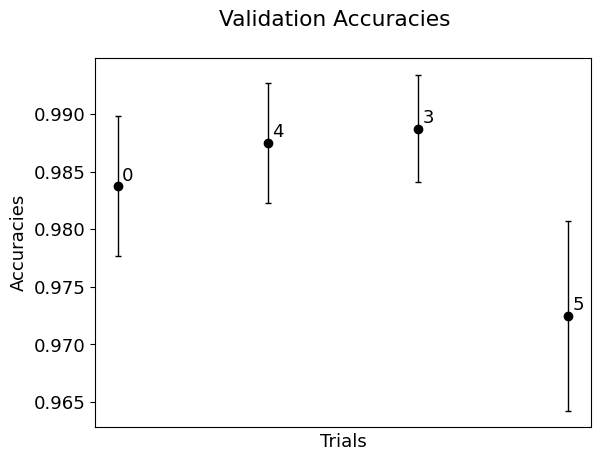

In [16]:
fig, ax = plt.subplots()
fig.suptitle('Validation Accuracies')
ax.errorbar((x_CV := range(len(results))), (y_CV := [results[i][0] for i in range(len(results))]), yerr=[results[i][1] for i in range(len(results))], fmt='ok', capsize=2, elinewidth=1)
for i, txt in enumerate([0,4,3,5]): ax.annotate(txt, (x_CV[i] + 0.03, y_CV[i]+0.0005))
ax.get_xaxis().set_ticks([])
ax.set_ylabel('Accuracies')
ax.set_xlabel('Trials')
plt.show()

## Training

In [61]:
fit = best_model.fit(x_train, y_train, batch_size = 50, validation_data=(x_test,y_test), verbose=0) # Training best model and evaluating it using the test dataset

In the graphs below we see that loss and accuracy for train data and validation data stays kind of static, thanks to the Random Search method we already selected the best hyper parameter of the model.

In [62]:
def train_data(x_train,y_train,x_test,y_test):
    '''
    Fits train and test set using the best model found above, and plots the relative scores.
    '''
    nepoch = 400
    fit = best_model.fit(x_train, y_train,
               epochs = nepoch, batch_size = 50,
               validation_data=(x_test,y_test),
               verbose=0)
    
    fig,AX=plt.subplots(1,2,figsize=(12,5.), layout='constrained')
    ax=AX[0]
    ax.plot(fit.history['accuracy'],label="train",c="b", lw=0.7)
    ax.plot(fit.history['val_accuracy'],label="test",c="r", lw=0.7)
    ax.set_xlabel('Epoch')
    ax.set_ylabel("Accuracy")
    ax.set_xlim(0,400)
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],label="train",c="b", lw=0.7)
    ax.plot(fit.history['val_loss'],label="test",c="r", lw=0.7)
    ax.set_xlabel('Epoch')
    ax.set_xlim(0,400)
    ax.set_ylabel("Loss")
    ax.legend()

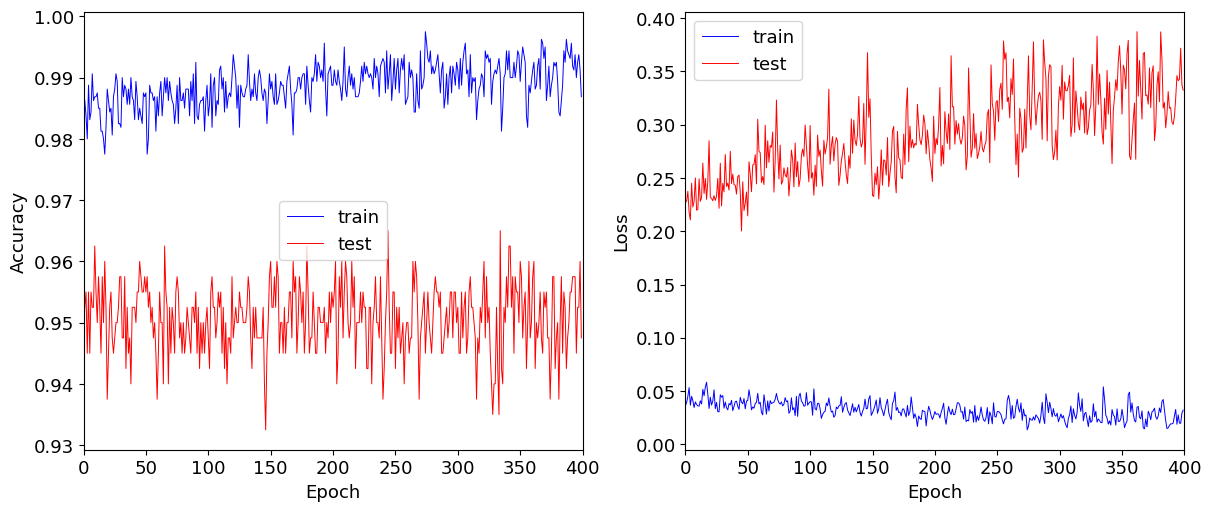

In [63]:
 
x_train,y_train,x_test,y_test=prepare_data(x,y)
train_data(x_train,y_train,x_test,y_test)


## Grid to show preditions

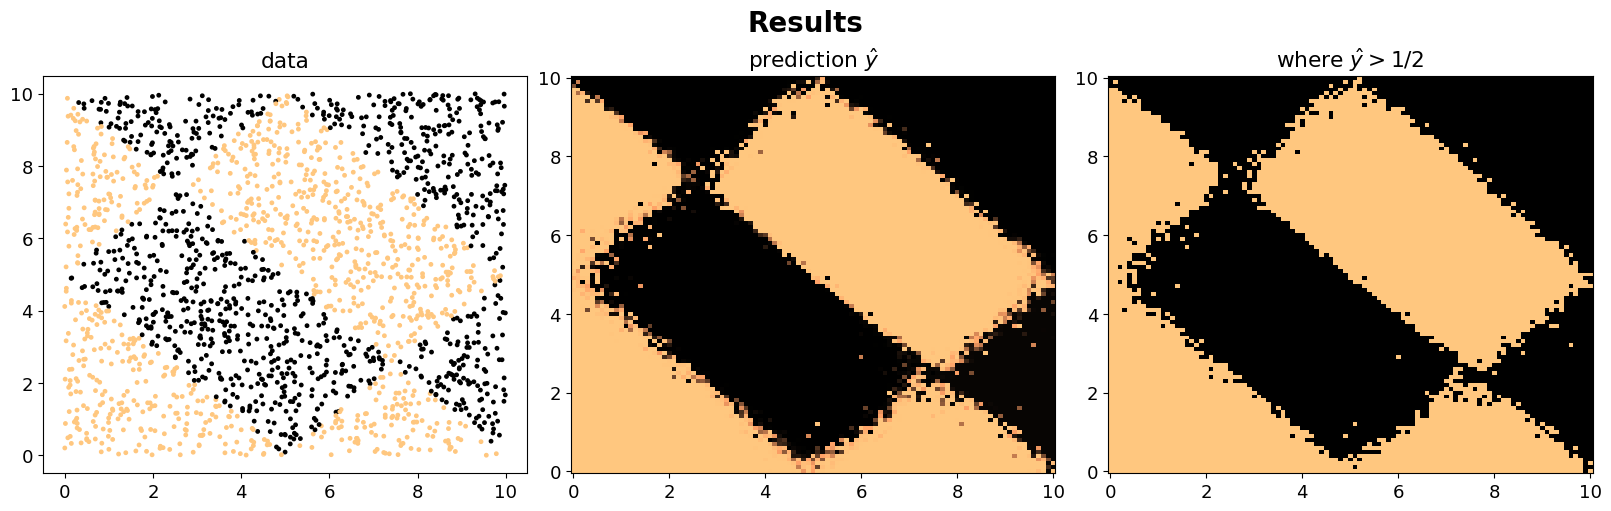

In [69]:
x_mean = np.mean(x,axis=0)
x_std  = np.std(x,axis=0)
dX = .1
X1 = np.arange(0,10+dX, dX)
LG = len(X1)
X, Y = np.meshgrid(X1, X1)
allXY = np.reshape((np.array((X,Y)).T),(LG**2,2))
grid = np.random.rand(LG**2,L)*B
grid[:,:2] = allXY
grid_r=Standardize(grid,x_mean,x_std)

pred = best_model.predict(grid_r, verbose=0)

fig,AX=plt.subplots(1,3,figsize=(16,5.), layout='constrained')
fig.suptitle('Results', weight='bold',fontsize=20)
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y,s=6)
ax.set_title("data")
ax=AX[1]
ax.pcolormesh(X1,X1,pred.reshape((LG, LG)))
ax.set_title("prediction $\\hat y$")
ax=AX[2]
pred01=np.copy(pred)
pred01[pred>0.5]=1
pred01[pred<=0.5]=0
ax.pcolormesh(X1,X1,pred01.reshape((LG, LG)))
ax.set_title("where $\\hat y > 1/2$")
plt.show()

## 2) Data Augmentation/Reduction

Given the best_model found in part 1, we study its performance when fitting on different data sets. At first we test the model on an increased dataset, which is generated in the same way as the original, but with a larger size.
Finally, we modify the training set by doing reduction (we halve the size of the training set) and augmentation (generating new data based on the original training set).

In [80]:
import random

TYPE=3
L=8
N_inc=9000
B=10

# ORIGINAL
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")

# REDUCTED
index = random.sample(range(len(x)),int(0.5*x.shape[0]))
x_reducted = x[index]
y_reducted = y[index]

x_reducted=np.array(x_reducted)
y_reducted=np.array(y_reducted)


# INCREASED
np.random.seed(1)
x_increased=np.random.random((N_inc,L))*B #number between (0,1) * width of data sample
y_increased=list(np.zeros(N_inc))
for i in range(N_inc):
    y_increased[i]=NF(x_increased[i],B,TYPE)

y_increased=np.array(y_increased)

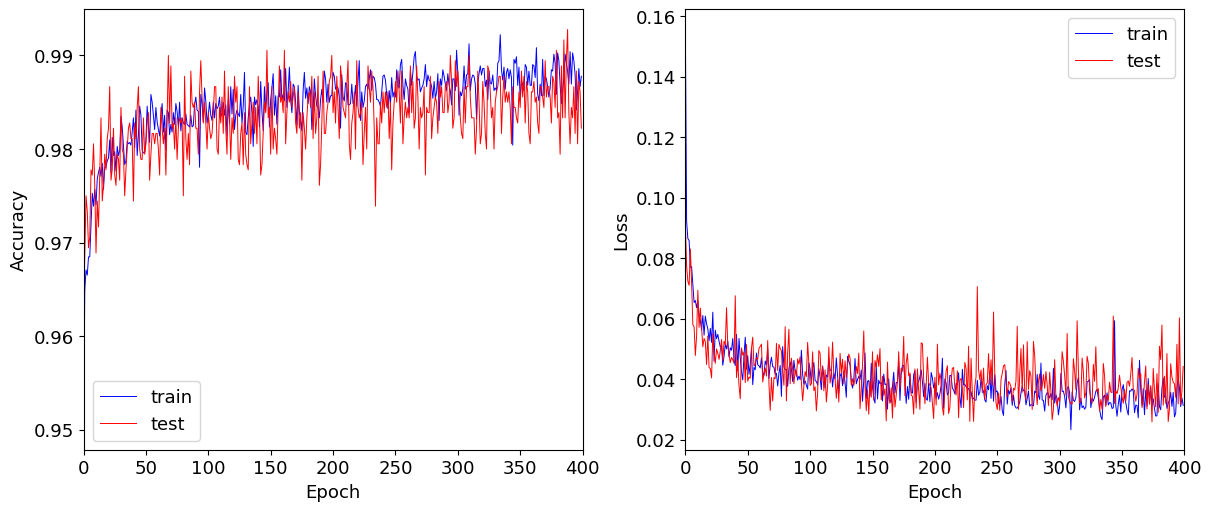

In [72]:
x_train,y_train,x_test,y_test=prepare_data(x_increased,y_increased)
train_data(x_train,y_train,x_test,y_test)


### Reduction
We define a function that reduces the dataset and returns the training and test sets. We then plot the loss and accuracy.
The reduction is done by sampling randomically half of the training set.


In [73]:

def reduction(x,y):
    '''
    Returns standardized training and test sets, where the training set gets reducted by half. 
    '''

    perc_train=0.8
    N=len(x)
    N_train = int(perc_train * N)
    x_mean = np.mean(x,axis=0)
    x_std  = np.std(x,axis=0)

    (x_train, y_train) = (x[0:N_train],y[0:N_train])
    (x_test, y_test) = (x[N_train:],y[N_train:])

    index= random.sample(range(len(x_train)),int(0.5*x.shape[0]))
    x_reducted = x_train[index]
    y_reducted = y_train[index]
    #plot_data(x_reducted,y_reducted)
    x_reducted=np.array(x_reducted)
    y_reducted=np.array(y_reducted)

    x_reducted = Standardize(x_reducted,x_mean,x_std)
    x_test = Standardize(x_test,x_mean,x_std)

    #print(x_reducted.shape)
    #print(y_reducted.shape)
    return x_reducted, y_reducted, x_test, y_test

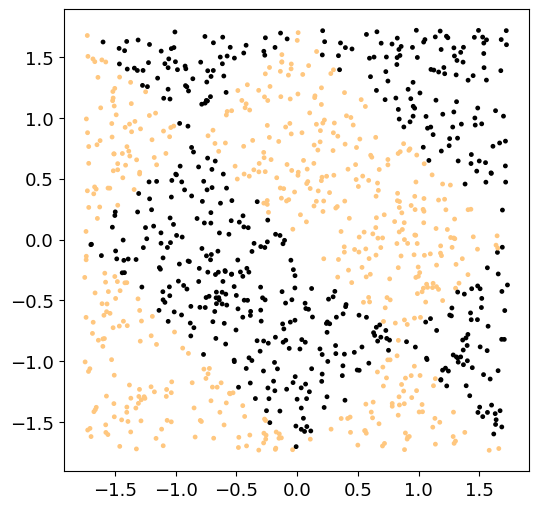

In [74]:
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")

x_train,y_train,x_test,y_test=reduction(x,y)
plot_data(x_train,y_train)

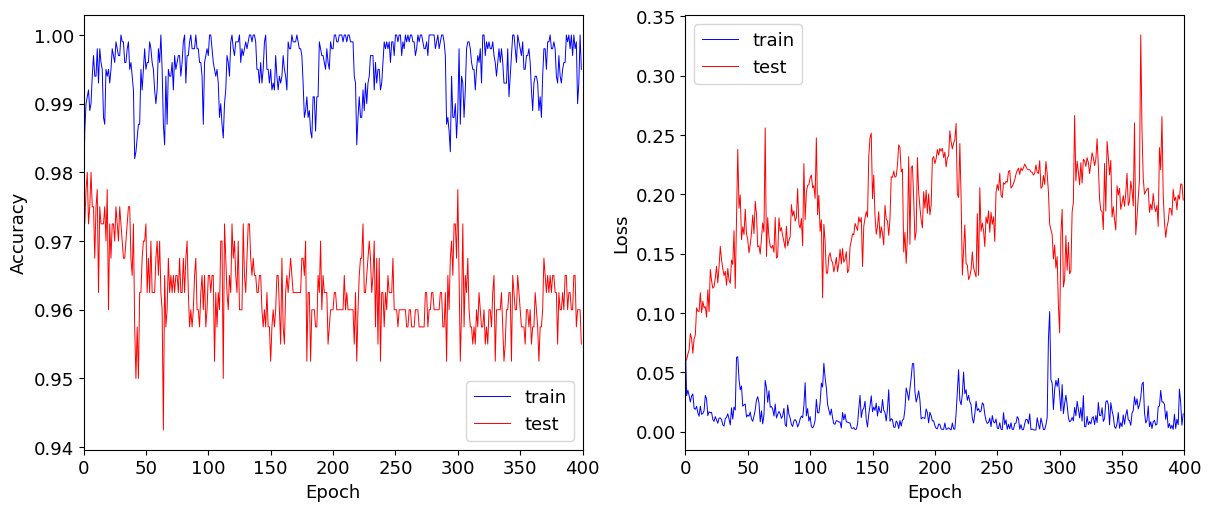

In [75]:
train_data(x_train,y_train,x_test,y_test)

### Augmentation

We define a function that executess the augmentation on the dataset and returns the training and test sets. We then plot the loss and accuracy.
The augmentation is implemented by picking n times the points of the train set and drawing a point from a normal distribution centered on each point of the set.



In [76]:

# AUGMENTED
def augmentation(x,y,n):
    '''
    returns standardized training and test sets.
    given N the length of the training set, the latter gets augmented returning ( N * 2**n ) train data.  
    '''
    perc_train=0.8
    N=len(x)
    N_train = int(perc_train * N)
    x_mean = np.mean(x,axis=0)
    x_std  = np.std(x,axis=0)

    (x_train, y_train) = (x[0:N_train],y[0:N_train])
    (x_test, y_test) = (x[N_train:],y[N_train:])


    N=len(x_train)
    x_augmented=x_train.copy()
    y_augmented=y_train.copy()
    
    for num_iterations in range(n):
        for i in range(0,N):
            lista=[]
            for j in range(L):
                lista.append(np.random.normal(loc=x[i,j],scale=0.1))
            x_augmented=np.append(x_augmented,[lista],axis=0)
            y_aug=y[i]
            y_augmented=np.append(y_augmented,y_aug)

    x_augmented=np.array(x_augmented)
    y_augmented=np.array(y_augmented)

    x_augmented = Standardize(x_augmented,x_mean,x_std)
    x_test = Standardize(x_test,x_mean,x_std)

    return x_augmented,y_augmented,x_test,y_test

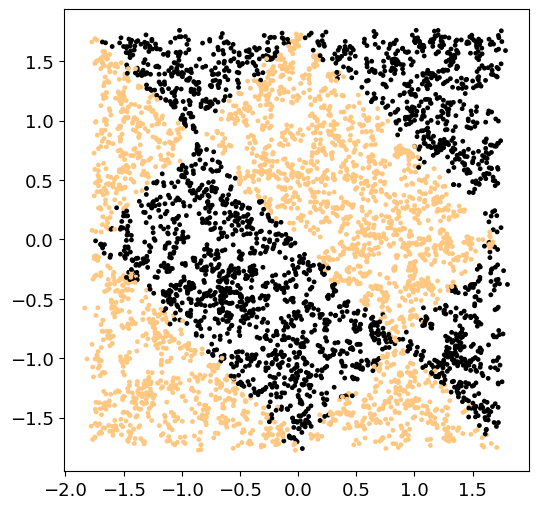

In [77]:
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")

n=2
x_train,y_train,x_test,y_test= augmentation(x,y,n)
plot_data(x_train,y_train)

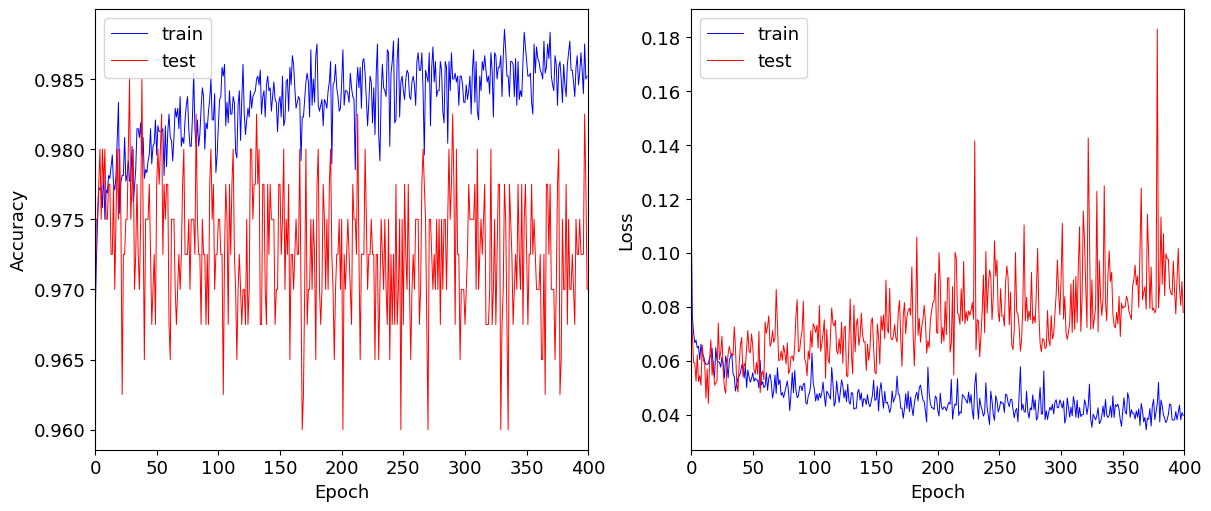

In [78]:
train_data(x_train,y_train,x_test,y_test)
